# Undersampling function

In [1]:
import pandas as pd
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis, euclidean
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances

class DataProcessor:
    def __init__(self, data, class_col, feature_cols):
        """
        Initialize the DataProcessor class.

        Parameters:
            data (pd.DataFrame): The dataset.
            class_col (str): The column name for class labels.
            feature_cols (list of str): List of column names for features.
        """
        self.data = data
        self.class_col = class_col
        self.maj_class=None
        self.feature_cols = feature_cols
        self.filtered_data = None
        self.noise = None
        self.undersampled_data = None
        self.delated = None
#        self.data_plot=None

    def calculate_posterior_probabilities(self):
        """
        Calculate posterior probabilities for the dataset using Bayes' theorem.
        """
        classes = self.data[self.class_col].unique()
        if len(classes) != 2:
            raise ValueError("This method supports binary classification only.")
        
        class_0, class_1 = classes

        # Compute priors
        prior_0 = len(self.data[self.data[self.class_col] == class_0]) / len(self.data)
        prior_1 = len(self.data[self.data[self.class_col] == class_1]) / len(self.data)

        # Compute means and variances for each class and feature
        stats_0 = self.data[self.data[self.class_col] == class_0][self.feature_cols].agg(['mean', 'var'])
        stats_1 = self.data[self.data[self.class_col] == class_1][self.feature_cols].agg(['mean', 'var'])

        # Compute posterior probabilities
        def posterior_probability(row):
            likelihood_0 = np.prod([
                np.exp(-0.5 * ((row[col] - stats_0.at['mean', col]) ** 2) / stats_0.at['var', col]) /
                np.sqrt(2 * np.pi * stats_0.at['var', col])
                for col in self.feature_cols
            ])
            likelihood_1 = np.prod([
                np.exp(-0.5 * ((row[col] - stats_1.at['mean', col]) ** 2) / stats_1.at['var', col]) /
                np.sqrt(2 * np.pi * stats_1.at['var', col])
                for col in self.feature_cols
            ])

            posterior_0 = prior_0 * likelihood_0
            posterior_1 = prior_1 * likelihood_1

            if posterior_0 + posterior_1 == 0:  # Avoid division by zero
                return 0.5
            return posterior_1 / (posterior_0 + posterior_1)

        self.data['p_other_class'] = self.data.apply(posterior_probability, axis=1)

    def compute_tacf(self, threshold_type, threshold_value, min_features=2):
        """
        Apply the Threshold-Adjusted Classification Filter (TACF) algorithm.

        Parameters:
            threshold_type (str): Type of threshold to use, either 'percent' or 'std'.
            threshold_value (float): Value of the threshold (e.g., 10 for percent or 1.5 for std).
            min_features (int): Minimum number of features exceeding the threshold to classify as noise.
        """
        classes = self.data[self.class_col].unique()
        if len(classes) != 2:
            raise ValueError("TACF currently supports binary classification only.")

        class_p, class_n = classes
        data_p = self.data[self.data[self.class_col] == class_p].copy()
        data_n = self.data[self.data[self.class_col] == class_n].copy()

        if threshold_type == 'percent':
            p_threshold_p = np.percentile(data_p['p_other_class'], 100 - threshold_value)
            p_threshold_n = np.percentile(data_n['p_other_class'], 100 - threshold_value)

            noisy_p = data_p[data_p['p_other_class'] > p_threshold_p]
            noisy_n = data_n[data_n['p_other_class'] > p_threshold_n]

            data_p = data_p[data_p['p_other_class'] <= p_threshold_p]
            data_n = data_n[data_n['p_other_class'] <= p_threshold_n]

        elif threshold_type == 'std':
            stats_p = data_p[self.feature_cols].agg(['mean', 'std'])
            stats_n = data_n[self.feature_cols].agg(['mean', 'std'])

            def is_noisy(row, stats, threshold_value, min_features):
                count = sum(
                    abs(row[col] - stats.at['mean', col]) > threshold_value * stats.at['std', col]
                    for col in self.feature_cols
                )
                return count >= min_features

            noisy_p = data_p[data_p.apply(lambda row: is_noisy(row, stats_p, threshold_value, min_features), axis=1)]
            noisy_n = data_n[data_n.apply(lambda row: is_noisy(row, stats_n, threshold_value, min_features), axis=1)]

            data_p = data_p[~data_p.index.isin(noisy_p.index)]
            data_n = data_n[~data_n.index.isin(noisy_n.index)]

        else:
            raise ValueError("Invalid threshold_type. Use 'percent' or 'std'.")

        self.filtered_data = pd.concat([data_p, data_n]).sort_index()
        self.noise = pd.concat([noisy_p, noisy_n]).sort_index()
  #      data_with_labels=self.data.copy()
 #       data_with_labels['is_noise'] = 0  # Initialize all points as non-noise
#        data_with_labels.loc[self.noise.index, 'is_noise'] = 1  # Mark noisy points
        # Store the original dataset with noise labels for visualization
#        self.data_plot = data_with_labels
    def _calculate_potential(self, x, majority_class, minority_class, gamma):
        """
        Calculate the mutual class potential for a point x.

        Parameters:
            x (array-like): The point for which to calculate the potential.
            majority_class (array-like): Majority class observations.
            minority_class (array-like): Minority class observations.
            gamma (float): Spread parameter for the RBF.

        Returns:
            float: Mutual class potential at point x.
        """
        dist_majority = euclidean_distances([x], majority_class)
        dist_minority = euclidean_distances([x], minority_class)

        potential_majority = np.sum(np.exp(-(dist_majority / gamma) ** 2))
        potential_minority = np.sum(np.exp(-(dist_minority / gamma) ** 2))

        return potential_majority - potential_minority

    def mutual_class_potential_undersample(self, gamma=1.0):
        """
        Undersample the majority class using mutual class potential.
        
        Parameters:
            gamma (float): Spread parameter for the RBF.
        
        Returns:
            pd.DataFrame: Undersampled dataset with original indices.
            pd.DataFrame: Deleted dataset with original indices.
        """
        if self.undersampled_data is None:
            raise ValueError("Noise removal must be performed before undersampling.")
        classes = self.data[self.class_col].unique()
        # Extract majority and minority class samples with their original indices
        majority_class = self.undersampled_data[self.undersampled_data[self.class_col] == self.maj_class]
        minority_class = self.undersampled_data[self.undersampled_data[self.class_col] == classes[1] if classes[0] == self.maj_class else classes[0]]
        
        # Store the original indices of the majority class samples
        majority_indices = majority_class.index
        majority_class_values = majority_class[self.feature_cols].values
        minority_class_values = minority_class[self.feature_cols].values
        
        # Calculate mutual class potential for each majority sample
        potentials = [
            self._calculate_potential(x, majority_class_values, minority_class_values, gamma)
            for x in majority_class_values
        ]
        
        # Determine the number of samples to remove
        n_majority = len(majority_class_values)
        n_minority = len(minority_class_values)
        n_to_remove = n_majority - 2 * n_minority  # Remove until majority is <= 2 * minority
        if n_to_remove > 0:
            # Get the indices of the majority class samples to remove based on potential (highest first)
            remove_indices = []
            for _ in range(n_to_remove):
                # Find the index of the majority sample with the highest potential
                highest_potential_index = np.argmax(potentials)
                remove_indices.append(majority_indices[highest_potential_index])
                potentials[highest_potential_index] = -np.inf  # Mark this sample as removed by setting its potential to -inf
        
            # Get the indices of the majority class samples to keep
            keep_indices = majority_indices.difference(remove_indices)
        
            # Create the undersampled majority class
            undersampled_majority = self.undersampled_data.loc[keep_indices]
            delated_majority = self.undersampled_data.loc[remove_indices]
        else:
            # No samples to remove
            undersampled_majority = majority_class
            delated_majority = pd.DataFrame(columns=self.undersampled_data.columns)
        
        # Combine the undersampled majority class with the minority class
        undersampled_data = pd.concat([undersampled_majority, minority_class])
        delated_data = delated_majority
        
        return undersampled_data, delated_data

    def local_gran_subspaces(self, dataset):
        """
        Generate local granular subspaces by dropping one feature at a time.

        Parameters:
            dataset (pd.DataFrame): The dataset to process.

        Returns:
            list: List of subspaces.
        """
        subsp_list = []
        for i in dataset.columns:
            subsp = dataset.drop(columns=[i])
            subsp_list.append(subsp)
        return subsp_list

    def calculate_and_sort_distances(self, dataset, distance_type="euclidean"):
        """
        Calculate distances (Mahalanobis or Euclidean) and sort the dataset.

        Parameters:
            dataset (pd.DataFrame): The dataset to process.
            distance_type (str): Type of distance to use, either 'euclidean' or 'mahalanobis'.

        Returns:
            pd.DataFrame: Sorted dataset with distances.
        """
        X = dataset.iloc[:, :-1]
        mean_vector = X.mean(axis=0)
        distances = []
        if distance_type == "mahalanobis":
            cov_matrix = np.cov(X, rowvar=False)
            inv_cov_matrix = np.linalg.inv(cov_matrix)
            for _, row in X.iterrows():
                distances.append(mahalanobis(row, mean_vector, inv_cov_matrix))
        elif distance_type == "euclidean":
            for _, row in X.iterrows():
                distances.append(euclidean(row, mean_vector))
        else:
            raise ValueError("Unsupported distance type. Use 'euclidean' or 'mahalanobis'.")
        dataset_with_distances = dataset.copy()
        dataset_with_distances['distance'] = distances
        sorted_dataset = dataset_with_distances.sort_values(by='distance').reset_index(drop=True)
        return sorted_dataset

    def mark_tomek_links(self, dataset, labels, maj):
        """
        Mark Tomek links in the dataset.

        Parameters:
            dataset (pd.DataFrame): The dataset to process.
            labels (pd.Series): The class labels.
            maj: The majority class label.

        Returns:
            pd.DataFrame: Dataset with Tomek links marked.
        """
        nbrs = NearestNeighbors(n_neighbors=2).fit(dataset)
        distances, indices = nbrs.kneighbors(dataset)
        tomek_link_mark = np.zeros(len(dataset), dtype=int)
        for i in range(len(dataset)):
            neighbor_index = indices[i, 1]
            if labels.iloc[i] != labels.iloc[neighbor_index]:
                if labels.iloc[i] == maj:
                    tomek_link_mark[i] = 1
                elif labels.iloc[neighbor_index] == maj:
                    tomek_link_mark[neighbor_index] = 1
        result_dataset = dataset.copy()
        result_dataset['tomek_link'] = tomek_link_mark
        return result_dataset, tomek_link_mark

    def combine_tomek_marks(self, dataset, labels, maj):
        """
        Combine Tomek marks from all subspaces.

        Parameters:
            dataset (pd.DataFrame): The dataset to process.
            labels (pd.Series): The class labels.
            maj: The majority class label.

        Returns:
            pd.DataFrame: Combined Tomek marks.
        """
        subspaces = self.local_gran_subspaces(dataset)
        combined_tomek_marks = pd.DataFrame(index=dataset.index)
        for i in range(len(subspaces)):
            _, tomek_mark = self.mark_tomek_links(subspaces[i], labels, maj)
            combined_tomek_marks[f'tomek_link_{dataset.columns[i]}'] = tomek_mark
        return combined_tomek_marks

    def undersample(self, maj_class, gamma=1.0, ratio = 0.5):
        """
        Undersample the majority class using Tomek links and mutual class potential.

        Parameters:
            maj_class: The majority class label.
            gamma (float): Spread parameter for the RBF.
        """
        if self.filtered_data is None:
            raise ValueError("Noise removal must be performed before undersampling.")
        self.maj_class=maj_class
        # Step 1: Undersample using Tomek links
        combined_marks = self.combine_tomek_marks(self.filtered_data[self.feature_cols], self.filtered_data[self.class_col], maj_class)
        combined_marks['total'] = combined_marks.sum(axis=1)

        to_remove = combined_marks[combined_marks['total'] > 0].index
        not_removed = combined_marks[combined_marks['total'] <= 0].index
        self.undersampled_data = self.filtered_data.drop(to_remove)
        self.delated = self.filtered_data.drop(not_removed)

        # Step 2: Check if majority class is still more than twice the minority class
        n_majority = len(self.undersampled_data[self.undersampled_data[self.class_col] == maj_class])
        n_minority = len(self.undersampled_data[self.undersampled_data[self.class_col] != maj_class])
        
        if ratio*n_majority > n_minority:
            # Apply mutual class potential undersampling
            self.undersampled_data, delated = self.mutual_class_potential_undersample(gamma)
            delated_df = delated # Выбираем строки по индексам
            delated_df[self.class_col] = maj_class  # Ensure class column is included
            if self.delated is None:
                self.delated = delated_df
            else:
                self.delated = pd.concat([self.delated, delated_df])
        return self.undersampled_data

    def visualize(self, title="UMAP Projection",mode='noise'):
        """
        Visualize the dataset using UMAP.

        Parameters:
            title (str): Title of the plot.
        """
        if self.filtered_data is None:
            raise ValueError("Noise removal must be performed before visualization.")
        # Use filtered_data or undersampled_data if available
        if mode == 'noise':
            data = self.data
        else:
            data = self.filtered_data
        reducer = umap.UMAP(random_state=0,n_neighbors=5)
        umap_embeddings = reducer.fit_transform(data[self.feature_cols])
        # Add UMAP embeddings to the dataset
        data["UMAP1"] = umap_embeddings[:, 0]
        data["UMAP2"] = umap_embeddings[:, 1]
        majority_class = data[self.class_col].mode()[0]
        if mode == 'noise':
            filtered_data=self.filtered_data
            noise = self.noise
            filtered_data["UMAP1"] = data.loc[self.filtered_data.index, "UMAP1"]
            filtered_data["UMAP2"] = data.loc[self.filtered_data.index, "UMAP2"]
            noise["UMAP1"] = data.loc[self.noise.index, "UMAP1"]
            noise["UMAP2"] = data.loc[self.noise.index, "UMAP2"]
        else:
            filtered_data=self.undersampled_data
            noise = self.delated
            filtered_data["UMAP1"] = data.loc[self.undersampled_data.index, "UMAP1"]
            filtered_data["UMAP2"] = data.loc[self.undersampled_data.index, "UMAP2"]
            noise["UMAP1"] = data.loc[self.delated.index, "UMAP1"]
            noise["UMAP2"] = data.loc[self.delated.index, "UMAP2"]
        
        # Plot scatterplot
        plt.figure(figsize=(10, 8), dpi=120)
        # Plot majority and minority points
        if mode == 'noise':
            # Plot noisy points as crosses
            plt.scatter(
                filtered_data.loc[filtered_data[self.class_col] == majority_class, "UMAP1"],
                filtered_data.loc[filtered_data[self.class_col] == majority_class, "UMAP2"],
                c="lightblue", s = 100, alpha=0.6, label="Majority Class", edgecolor="k", linewidth=0.5
            )
            
            plt.scatter(
                filtered_data.loc[filtered_data[self.class_col] != majority_class, "UMAP1"],
                filtered_data.loc[filtered_data[self.class_col] != majority_class, "UMAP2"],
                c="yellow",s =100, alpha=0.6, label="Minority Class", edgecolor="k", linewidth=0.5
            )
            plt.scatter(
                noise.loc[noise[self.class_col] == majority_class, "UMAP1"],
                noise.loc[noise[self.class_col] == majority_class, "UMAP2"],
                c="blue",s = 100, alpha=0.8, label="Noisy Majority", marker="x"
            )
            
            plt.scatter(
                noise.loc[noise[self.class_col] != majority_class, "UMAP1"],
                noise.loc[noise[self.class_col] != majority_class, "UMAP2"],
                c="orange",s = 100, alpha=0.8, label="Noisy Minority", marker="x"
            )
        elif mode == 'undersampling':
            plt.scatter(
                noise["UMAP1"],
                noise["UMAP2"],
                c="black",s = 20, alpha=0.6, label="Deleted data", marker="x"
            ) 
            plt.scatter(
                filtered_data.loc[filtered_data[self.class_col] == majority_class, "UMAP1"],
                filtered_data.loc[filtered_data[self.class_col] == majority_class, "UMAP2"],
                c="lightblue",s = 100, alpha=0.6, label="Majority Class", edgecolor="k", linewidth=0.5
            )
            
            plt.scatter(
                filtered_data.loc[filtered_data[self.class_col] != majority_class, "UMAP1"],
                filtered_data.loc[filtered_data[self.class_col] != majority_class, "UMAP2"],
                c="yellow",s = 100, alpha=0.6, label="Minority Class", edgecolor="k", linewidth=0.5
            )

        plt.legend(fontsize=12, loc="best")
        plt.xticks([])
        plt.yticks([])
        plt.xlabel("")
        plt.ylabel("")
        plt.title("")
        plt.grid(False)
        plt.show()

## Functions for model training

In [2]:
def split_test(data,number,i):
    class_0 = data[data.iloc[:,-1] == 0]
    class_1 = data[data.iloc[:,-1] == 1]
    test_size_per_class = number
    if class_0.empty or class_1.empty:
        raise ValueError("One of the classes is empty. Please ensure the dataset contains both classes.")
    class_0_test = class_0.sample(test_size_per_class, random_state=i)
    class_1_test = class_1.sample(test_size_per_class, random_state=i)
    test_set = pd.concat([class_0_test, class_1_test])
    train_set = data.drop(test_set.index)
    X_train = train_set.iloc[:,:-1]
    y_train = train_set.iloc[:,-1]
    X_test = test_set.iloc[:,:-1]
    y_test = test_set.iloc[:,-1]
    print("Training set:")
    print(y_train.value_counts())
    print("\nTest set:")
    print(y_test.value_counts())
    return X_train,X_test,y_train,y_test

In [3]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
import numpy as np

def rndf_weights(data, test_min, rnd1, rnd2,mode, n_splits):
    X_train_full, X_test1, y_train_full, y_test1 = split_test(data, test_min, rnd1)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rnd2)
    fold = 1
    evals = []
    if mode == 'original':
        class_weights='balanced_subsample'
    else:
        class_weights=None
    for train_index, val_index in kf.split(X_train_full, y_train_full):
        X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
        y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]        
        model = RandomForestClassifier(
            n_estimators=50,
            max_depth=7,
            criterion='gini',
            min_samples_leaf=10,
            min_samples_split=18,
            n_jobs=-1,
            random_state=42,
            class_weight=class_weights
        )
        model.fit(X_train, y_train)
        val_pred_proba = model.predict_proba(X_val)[:, 1]
        val_pred_binary = (val_pred_proba > 0.5).astype(int)
        accuracy = accuracy_score(y_val, val_pred_binary)
        auc_score = roc_auc_score(y_val, val_pred_proba)
        precision = precision_score(y_val, val_pred_binary)
        recall = recall_score(y_val, val_pred_binary)
        
        evals.append({
            'fold': fold,
            'accuracy': accuracy,
            'auc': auc_score,
            'precision': precision,
            'recall': recall
        })
        
        print(f"Fold {fold} - Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
        fold += 1
    
    test_pred_proba = model.predict_proba(X_test1)[:, 1]
    test_pred_binary = (test_pred_proba > 0.5).astype(int)
    test_accuracy = accuracy_score(y_test1, test_pred_binary)
    test_auc_score = roc_auc_score(y_test1, test_pred_proba)
    test_precision = precision_score(y_test1, test_pred_binary)
    test_recall = recall_score(y_test1, test_pred_binary)
    print(f"\nTest Data Evaluation - Accuracy: {test_accuracy:.4f}, AUC: {test_auc_score:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    return test_accuracy,test_auc_score,test_precision,test_recall

In [4]:
from sklearn.model_selection import StratifiedKFold, train_test_split
import lightgbm as lgb
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
def lgbm_weights(data,test_min, rnd1=42,rnd2=42,mode = 'original', n_splits=2):
    X_train_full, X_test1, y_train_full, y_test1 = split_test(data, test_min, rnd1)
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rnd2)
    fold = 1
    evals = []
    if mode == 'original':
        params = {
            'objective': 'binary',       
            'metric': 'binary_logloss',  
            'verbosity': -1,
            'is_unbalance': True,
            'class_label': 'is_unbalance'}
    else :
        params = {
            'objective': 'binary',       
            'metric': 'binary_logloss',  
            'verbosity': -1}
    for train_index, val_index in kf.split(X_train_full, y_train_full):
        X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
        y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)
        model = lgb.train(
            params,
            train_data,
            valid_sets=[train_data, val_data],
            callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)]
        )
        val_pred = model.predict(X_val)
        val_pred_binary = (val_pred > 0.5).astype(int)
        accuracy = accuracy_score(y_val, val_pred_binary)
        auc_score = roc_auc_score(y_val, val_pred)
        precision = precision_score(y_val, val_pred_binary)
        recall = recall_score(y_val, val_pred_binary)
        evals.append({
            'fold': fold,
            'accuracy': accuracy,
            'auc': auc_score,
            'precision': precision,
            'recall': recall
        })
        print(f"Fold {fold} - Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
        fold += 1
    test_pred = model.predict(X_test1)
    test_pred_binary = (test_pred > 0.5).astype(int)
    test_accuracy = accuracy_score(y_test1, test_pred_binary)
    test_auc_score = roc_auc_score(y_test1, test_pred)
    test_precision = precision_score(y_test1, test_pred_binary)
    test_recall = recall_score(y_test1, test_pred_binary)
    print(f"\nTest Data Evaluation - Accuracy: {test_accuracy:.4f}, AUC: {test_auc_score:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import random
from importlib.resources import path

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False



def mlp_weight(overs_data, test_min, rnd1=42, rnd2=42, epochs=50, batch_size=32, lr=0.001):
    X_train_full, X_test1, y_train_full, y_test1 = split_test(overs_data, test_min, rnd1)
    
    
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=rnd2)
    fold = 1
    evals = []
    set_random_seed(42)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_dim = X_train_full.shape[1]
    
    for train_index, val_index in kf.split(X_train_full, y_train_full):
        X_train, X_val = X_train_full.iloc[train_index].values, X_train_full.iloc[val_index].values
        y_train, y_val = y_train_full.iloc[train_index].values, y_train_full.iloc[val_index].values
        
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)
        
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
        
        # Определяем MLP-модель внутри функции
        model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        ).to(device)

        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        for epoch in range(epochs):
            model.train()
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val_tensor).cpu().numpy().flatten()
            val_preds_binary = (val_preds > 0.5).astype(int)
        
        accuracy = accuracy_score(y_val, val_preds_binary)
        auc_score = roc_auc_score(y_val, val_preds)
        precision = precision_score(y_val, val_preds_binary)
        recall = recall_score(y_val, val_preds_binary)
        evals.append({'fold': fold, 'accuracy': accuracy, 'auc': auc_score, 'precision': precision, 'recall': recall})
        print(f"Fold {fold} - Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
        fold += 1
    
    X_test1_tensor = torch.tensor(X_test1.values, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        test_preds = model(X_test1_tensor).cpu().numpy().flatten()
        test_preds_binary = (test_preds > 0.5).astype(int)
    
    test_accuracy = accuracy_score(y_test1, test_preds_binary)
    test_auc_score = roc_auc_score(y_test1, test_preds)
    test_precision = precision_score(y_test1, test_preds_binary)
    test_recall = recall_score(y_test1, test_preds_binary)
    
    print(f"\nTest Data Evaluation - Accuracy: {test_accuracy:.4f}, AUC: {test_auc_score:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    return test_accuracy, test_auc_score, test_precision, test_recall


In [6]:
def lgbm_overs1(overs_data,n,test_min,rnd1=42,rnd2=42):
    X_train_full, X_test1, y_train_full, y_test1 = split_test(overs_data.iloc[:-n,:], test_min, rnd1)
    X_train_full1 = pd.concat([X_train_full, overs_data.iloc[-n:, :-1]], ignore_index=True)
    y_train_full1 = pd.concat([y_train_full, overs_data.iloc[-n:, -1]], ignore_index=True)
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=rnd2)
    fold = 1
    evals = []
    params = {
        'objective': 'binary',       
        'metric': 'binary_logloss',  
        'verbosity': -1
    }
    for train_index, val_index in kf.split(X_train_full1, y_train_full1):
        X_train, X_val = X_train_full1.iloc[train_index], X_train_full1.iloc[val_index]
        y_train, y_val = y_train_full1.iloc[train_index], y_train_full1.iloc[val_index]
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val)
        model = lgb.train(
            params,
            train_data,
            valid_sets=[train_data, val_data],
            callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)]
        )
        val_pred = model.predict(X_val)
        val_pred_binary = (val_pred > 0.5).astype(int)
        accuracy = accuracy_score(y_val, val_pred_binary)
        auc_score = roc_auc_score(y_val, val_pred)
        precision = precision_score(y_val, val_pred_binary)
        recall = recall_score(y_val, val_pred_binary)
        evals.append({
            'fold': fold,
            'accuracy': accuracy,
            'auc': auc_score,
            'precision': precision,
            'recall': recall
        })
        print(f"Fold {fold} - Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
        fold += 1
    test_pred = model.predict(X_test1)
    test_pred_binary = (test_pred > 0.5).astype(int)
    test_accuracy = accuracy_score(y_test1, test_pred_binary)
    test_auc_score = roc_auc_score(y_test1, test_pred)
    test_precision = precision_score(y_test1, test_pred_binary)
    test_recall = recall_score(y_test1, test_pred_binary)
    print(f"\nTest Data Evaluation - Accuracy: {test_accuracy:.4f}, AUC: {test_auc_score:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    return test_accuracy,test_auc_score,test_precision,test_recall

In [7]:
def rndf_overs1(overs_data,n,test_min,rnd1=42,rnd2=42):
    X_train_full, X_test1, y_train_full, y_test1 = split_test(overs_data.iloc[:-n,:], test_min, rnd1)
    X_train_full1 = pd.concat([X_train_full, overs_data.iloc[-n:, :-1]], ignore_index=True)
    y_train_full1 = pd.concat([y_train_full, overs_data.iloc[-n:, -1]], ignore_index=True)
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=rnd2)
    fold = 1
    evals = []
    for train_index, val_index in kf.split(X_train_full1, y_train_full1):
        X_train, X_val = X_train_full1.iloc[train_index], X_train_full1.iloc[val_index]
        y_train, y_val = y_train_full1.iloc[train_index], y_train_full1.iloc[val_index]        
        model = RandomForestClassifier(
            n_estimators=50,
            max_depth=7,
            criterion='gini',
            min_samples_leaf=10,
            min_samples_split=18,
            n_jobs=-1,
            random_state=42)
        model.fit(X_train, y_train)
        val_pred_proba = model.predict_proba(X_val)[:, 1]
        val_pred_binary = (val_pred_proba > 0.5).astype(int)
        accuracy = accuracy_score(y_val, val_pred_binary)
        auc_score = roc_auc_score(y_val, val_pred_proba)
        precision = precision_score(y_val, val_pred_binary)
        recall = recall_score(y_val, val_pred_binary)
        
        evals.append({
            'fold': fold,
            'accuracy': accuracy,
            'auc': auc_score,
            'precision': precision,
            'recall': recall
        })
        
        print(f"Fold {fold} - Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
        fold += 1
    
    test_pred_proba = model.predict_proba(X_test1)[:, 1]
    test_pred_binary = (test_pred_proba > 0.5).astype(int)
    test_accuracy = accuracy_score(y_test1, test_pred_binary)
    test_auc_score = roc_auc_score(y_test1, test_pred_proba)
    test_precision = precision_score(y_test1, test_pred_binary)
    test_recall = recall_score(y_test1, test_pred_binary)
    print(f"\nTest Data Evaluation - Accuracy: {test_accuracy:.4f}, AUC: {test_auc_score:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    return test_accuracy,test_auc_score,test_precision,test_recall

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from torch.utils.data import DataLoader, TensorDataset

def mlp_overs1(overs_data, n, test_min, rnd1=42, rnd2=42, epochs=50, batch_size=32, lr=0.001):
    X_train_full, X_test1, y_train_full, y_test1 = split_test(overs_data.iloc[:-n, :], test_min, rnd1)
    X_train_full1 = pd.concat([X_train_full, overs_data.iloc[-n:, :-1]], ignore_index=True)
    y_train_full1 = pd.concat([y_train_full, overs_data.iloc[-n:, -1]], ignore_index=True)
    
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=rnd2)
    fold = 1
    evals = []
    set_random_seed(42)
    class MLP(nn.Module):
        def __init__(self, input_dim):
            super(MLP, self).__init__()
            self.fc1 = nn.Linear(input_dim, 64)
            self.fc2 = nn.Linear(64, 32)
            self.fc3 = nn.Linear(32, 1)
            self.relu = nn.ReLU()
            self.sigmoid = nn.Sigmoid()
            
        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            x = self.sigmoid(self.fc3(x))
            return x
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_dim = X_train_full1.shape[1]
    
    for train_index, val_index in kf.split(X_train_full1, y_train_full1):
        X_train, X_val = X_train_full1.iloc[train_index].values, X_train_full1.iloc[val_index].values
        y_train, y_val = y_train_full1.iloc[train_index].values, y_train_full1.iloc[val_index].values
        
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
        y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)
        
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        model = MLP(input_dim).to(device)
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        for epoch in range(epochs):
            model.train()
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_preds = model(X_val_tensor).cpu().numpy().flatten()
            val_preds_binary = (val_preds > 0.5).astype(int)
        
        accuracy = accuracy_score(y_val, val_preds_binary)
        auc_score = roc_auc_score(y_val, val_preds)
        precision = precision_score(y_val, val_preds_binary)
        recall = recall_score(y_val, val_preds_binary)
        evals.append({'fold': fold, 'accuracy': accuracy, 'auc': auc_score, 'precision': precision, 'recall': recall})
        print(f"Fold {fold} - Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
        fold += 1
    
    X_test1_tensor = torch.tensor(X_test1.values, dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        test_preds = model(X_test1_tensor).cpu().numpy().flatten()
        test_preds_binary = (test_preds > 0.5).astype(int)
    
    test_accuracy = accuracy_score(y_test1, test_preds_binary)
    test_auc_score = roc_auc_score(y_test1, test_preds)
    test_precision = precision_score(y_test1, test_preds_binary)
    test_recall = recall_score(y_test1, test_preds_binary)
    
    print(f"\nTest Data Evaluation - Accuracy: {test_accuracy:.4f}, AUC: {test_auc_score:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")
    return test_accuracy, test_auc_score, test_precision, test_recall

# satimage

### Data Loading and Preprocessing

In [9]:
from collections import Counter
from imblearn.datasets import fetch_datasets
satimage = fetch_datasets()['satimage']
satimage.data.shape

(6435, 36)

In [10]:
import pandas as pd
import numpy as np
df = pd.DataFrame(satimage.data, columns=[f'feature_{i}' for i in range(satimage.data.shape[1])])
df['target'] = satimage.target
df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,target
0,92.0,115.0,120.0,94.0,84.0,102.0,106.0,79.0,84.0,102.0,...,104.0,88.0,121.0,128.0,100.0,84.0,107.0,113.0,87.0,-1
1,84.0,102.0,106.0,79.0,84.0,102.0,102.0,83.0,80.0,102.0,...,100.0,84.0,107.0,113.0,87.0,84.0,99.0,104.0,79.0,-1
2,84.0,102.0,102.0,83.0,80.0,102.0,102.0,79.0,84.0,94.0,...,87.0,84.0,99.0,104.0,79.0,84.0,99.0,104.0,79.0,-1
3,80.0,102.0,102.0,79.0,84.0,94.0,102.0,79.0,80.0,94.0,...,79.0,84.0,99.0,104.0,79.0,84.0,103.0,104.0,79.0,-1
4,84.0,94.0,102.0,79.0,80.0,94.0,98.0,76.0,80.0,102.0,...,79.0,84.0,103.0,104.0,79.0,79.0,107.0,109.0,87.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,60.0,83.0,96.0,85.0,64.0,87.0,100.0,88.0,64.0,83.0,...,92.0,66.0,87.0,108.0,89.0,63.0,83.0,104.0,85.0,-1
6431,64.0,79.0,100.0,85.0,56.0,71.0,96.0,85.0,56.0,68.0,...,85.0,66.0,83.0,100.0,85.0,63.0,83.0,100.0,81.0,-1
6432,56.0,68.0,91.0,81.0,56.0,64.0,91.0,81.0,53.0,64.0,...,81.0,59.0,87.0,96.0,81.0,63.0,83.0,92.0,74.0,-1
6433,56.0,68.0,87.0,74.0,60.0,71.0,91.0,81.0,60.0,64.0,...,74.0,59.0,83.0,92.0,74.0,59.0,83.0,92.0,70.0,-1


In [11]:
df['target'].value_counts()

target
-1    5809
 1     626
Name: count, dtype: int64

In [12]:
df.target.replace({-1:0},inplace=True)
df

C:\Users\Жибек\AppData\Local\Temp\ipykernel_21188\33722527.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.target.replace({-1:0},inplace=True)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,target
0,92.0,115.0,120.0,94.0,84.0,102.0,106.0,79.0,84.0,102.0,...,104.0,88.0,121.0,128.0,100.0,84.0,107.0,113.0,87.0,0
1,84.0,102.0,106.0,79.0,84.0,102.0,102.0,83.0,80.0,102.0,...,100.0,84.0,107.0,113.0,87.0,84.0,99.0,104.0,79.0,0
2,84.0,102.0,102.0,83.0,80.0,102.0,102.0,79.0,84.0,94.0,...,87.0,84.0,99.0,104.0,79.0,84.0,99.0,104.0,79.0,0
3,80.0,102.0,102.0,79.0,84.0,94.0,102.0,79.0,80.0,94.0,...,79.0,84.0,99.0,104.0,79.0,84.0,103.0,104.0,79.0,0
4,84.0,94.0,102.0,79.0,80.0,94.0,98.0,76.0,80.0,102.0,...,79.0,84.0,103.0,104.0,79.0,79.0,107.0,109.0,87.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,60.0,83.0,96.0,85.0,64.0,87.0,100.0,88.0,64.0,83.0,...,92.0,66.0,87.0,108.0,89.0,63.0,83.0,104.0,85.0,0
6431,64.0,79.0,100.0,85.0,56.0,71.0,96.0,85.0,56.0,68.0,...,85.0,66.0,83.0,100.0,85.0,63.0,83.0,100.0,81.0,0
6432,56.0,68.0,91.0,81.0,56.0,64.0,91.0,81.0,53.0,64.0,...,81.0,59.0,87.0,96.0,81.0,63.0,83.0,92.0,74.0,0
6433,56.0,68.0,87.0,74.0,60.0,71.0,91.0,81.0,60.0,64.0,...,74.0,59.0,83.0,92.0,74.0,59.0,83.0,92.0,70.0,0


### Application of the NAUS Algorithm

C:\conda\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


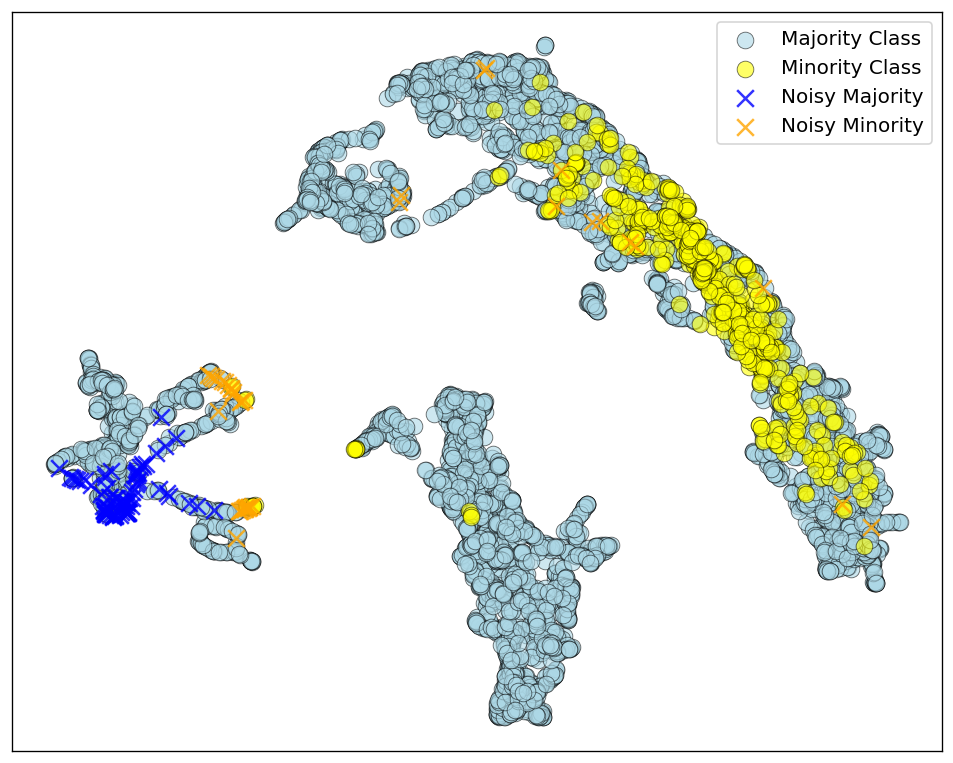

C:\conda\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


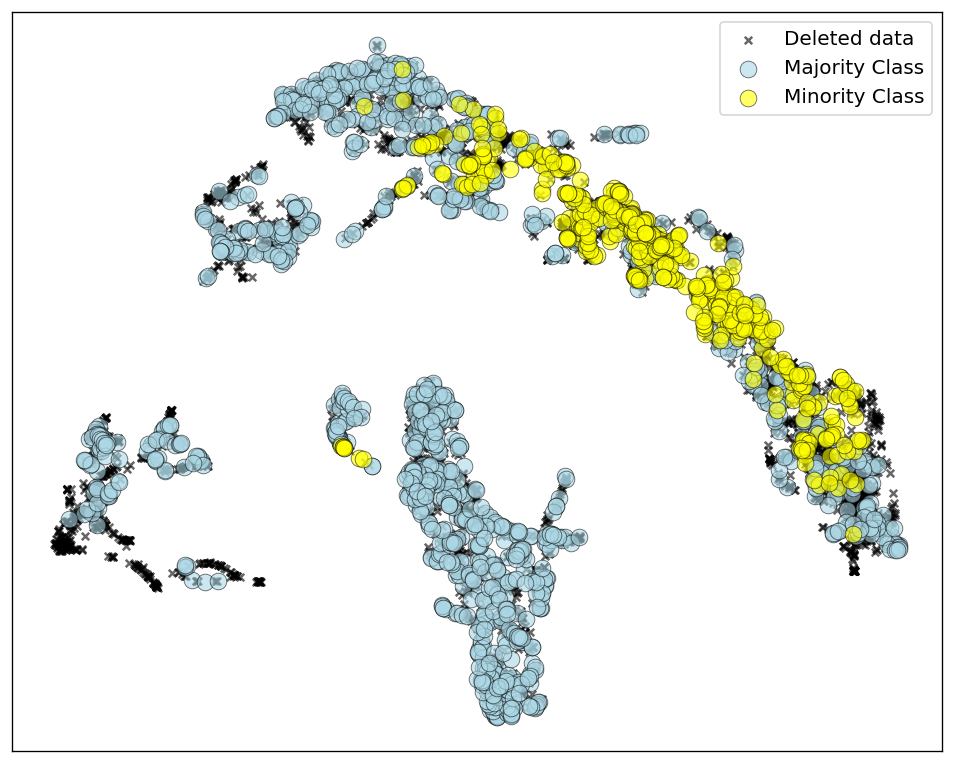

In [13]:
features = df.columns.drop("target")
processor = DataProcessor(df, class_col="target", feature_cols=features)

# Step 1: Calculate posterior probabilities
processor.calculate_posterior_probabilities()

# Step 2: Apply TACF for noise removal
processor.compute_tacf(threshold_type='std', threshold_value=3, min_features=2)
processor.visualize(title="UMAP Projection After Noise Removal",mode ='noise')
# Step 3: Undersample the majority class
result = processor.undersample(maj_class=0, gamma=1.0, ratio=0.5)

# Step 4: Visualize the results
processor.visualize(title="UMAP Projection After Undersampling", mode='undersampling')

In [14]:
# Class Ratio in the Final Dataset
result['target'].value_counts()

target
0    1172
1     586
Name: count, dtype: int64

In [15]:
# Removal of Redundant Features Generated During Computation
result = result.iloc[:,:-3]
df=df.iloc[:,:-3]
result

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,target
4975,60.0,61.0,71.0,59.0,60.0,61.0,75.0,63.0,60.0,61.0,...,70.0,59.0,60.0,84.0,70.0,59.0,56.0,80.0,70.0,0
4976,60.0,61.0,75.0,67.0,60.0,57.0,75.0,67.0,56.0,54.0,...,70.0,59.0,60.0,80.0,63.0,66.0,63.0,76.0,66.0,0
4977,53.0,48.0,67.0,56.0,56.0,54.0,79.0,63.0,56.0,54.0,...,52.0,56.0,46.0,69.0,52.0,56.0,49.0,69.0,55.0,0
4978,56.0,54.0,79.0,63.0,56.0,54.0,79.0,63.0,56.0,51.0,...,52.0,56.0,49.0,69.0,55.0,56.0,53.0,73.0,63.0,0
4979,53.0,54.0,71.0,52.0,53.0,51.0,75.0,63.0,53.0,48.0,...,59.0,52.0,49.0,76.0,59.0,56.0,53.0,84.0,63.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6246,76.0,85.0,98.0,76.0,72.0,81.0,86.0,72.0,68.0,73.0,...,79.0,79.0,95.0,96.0,79.0,75.0,87.0,93.0,79.0,1
6268,80.0,95.0,100.0,81.0,71.0,79.0,91.0,74.0,68.0,71.0,...,78.0,74.0,91.0,100.0,81.0,78.0,96.0,96.0,81.0,1
6360,67.0,77.0,110.0,90.0,75.0,91.0,97.0,79.0,79.0,91.0,...,94.0,76.0,89.0,106.0,87.0,76.0,89.0,98.0,79.0,1
6361,75.0,91.0,97.0,79.0,79.0,91.0,97.0,83.0,79.0,91.0,...,87.0,76.0,89.0,98.0,79.0,72.0,89.0,98.0,79.0,1


### Model Training

In [16]:
# Random forest on original data
rndf_weights(df,58,4,0,'original',2)

Training set:
target
0    5751
1     568
Name: count, dtype: int64

Test set:
target
0    58
1    58
Name: count, dtype: int64
Fold 1 - Accuracy: 0.8858, AUC: 0.9467, Precision: 0.4301, Recall: 0.8345
Fold 2 - Accuracy: 0.8987, AUC: 0.9406, Precision: 0.4620, Recall: 0.7711

Test Data Evaluation - Accuracy: 0.8534, AUC: 0.9560, Precision: 0.9020, Recall: 0.7931


(0.853448275862069, 0.9560047562425683, 0.9019607843137255, 0.7931034482758621)

In [17]:
# Random forest on undersampled data
rndf_weights(result,58,4,0,'undersampled',2)

Training set:
target
0    1114
1     528
Name: count, dtype: int64

Test set:
target
0    58
1    58
Name: count, dtype: int64
Fold 1 - Accuracy: 0.9050, AUC: 0.9719, Precision: 0.8661, Recall: 0.8333
Fold 2 - Accuracy: 0.9111, AUC: 0.9750, Precision: 0.8631, Recall: 0.8598

Test Data Evaluation - Accuracy: 0.9569, AUC: 0.9837, Precision: 0.9649, Recall: 0.9483


(0.9568965517241379,
 0.9836504161712247,
 0.9649122807017544,
 0.9482758620689655)

In [18]:
# LightGBM on original data
lgbm_weights(df,58,4,15,'original',2)

Training set:
target
0    5751
1     568
Name: count, dtype: int64

Test set:
target
0    58
1    58
Name: count, dtype: int64
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.146908	valid_1's binary_logloss: 0.196229
[20]	training's binary_logloss: 0.114342	valid_1's binary_logloss: 0.185475
[30]	training's binary_logloss: 0.0848781	valid_1's binary_logloss: 0.174255
[40]	training's binary_logloss: 0.0621571	valid_1's binary_logloss: 0.167145
[50]	training's binary_logloss: 0.0435243	valid_1's binary_logloss: 0.159296
[60]	training's binary_logloss: 0.0310029	valid_1's binary_logloss: 0.15562
[70]	training's binary_logloss: 0.0219132	valid_1's binary_logloss: 0.153591
[80]	training's binary_logloss: 0.0158848	valid_1's binary_logloss: 0.153376
Early stopping, best iteration is:
[79]	training's binary_logloss: 0.0164194	valid_1's binary_logloss: 0.153085
Fold 1 - Accuracy: 0.9386, AUC: 0.9573, Precision: 0.6471, Recall: 0.6972
Training unti

In [19]:
# LightGBM on undersampled data
lgbm_weights(result,58,4,15,'undersampled',2)

Training set:
target
0    1114
1     528
Name: count, dtype: int64

Test set:
target
0    58
1    58
Name: count, dtype: int64
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.266969	valid_1's binary_logloss: 0.308937
[20]	training's binary_logloss: 0.14583	valid_1's binary_logloss: 0.219829
[30]	training's binary_logloss: 0.0892844	valid_1's binary_logloss: 0.189944
[40]	training's binary_logloss: 0.0524591	valid_1's binary_logloss: 0.175067
[50]	training's binary_logloss: 0.0307887	valid_1's binary_logloss: 0.170682
[60]	training's binary_logloss: 0.0181035	valid_1's binary_logloss: 0.16987
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.0213874	valid_1's binary_logloss: 0.168116
Fold 1 - Accuracy: 0.9342, AUC: 0.9812, Precision: 0.8860, Recall: 0.9129
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.265983	valid_1's binary_logloss: 0.313462
[20]	training's binary_logloss:

In [20]:
# MLP on original data
mlp_weight(df,58,28,42)

Training set:
target
0    5751
1     568
Name: count, dtype: int64

Test set:
target
0    58
1    58
Name: count, dtype: int64


C:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 - Accuracy: 0.9101, AUC: 0.8070, Precision: 0.0000, Recall: 0.0000
Fold 2 - Accuracy: 0.9101, AUC: 0.8104, Precision: 0.0000, Recall: 0.0000

Test Data Evaluation - Accuracy: 0.5000, AUC: 0.8029, Precision: 0.0000, Recall: 0.0000


C:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.5, 0.8029131985731273, 0.0, 0.0)

In [22]:
mlp_weight(result,58,28,42)

Training set:
target
0    1114
1     528
Name: count, dtype: int64

Test set:
target
0    58
1    58
Name: count, dtype: int64
Fold 1 - Accuracy: 0.6931, AUC: 0.7973, Precision: 0.5769, Recall: 0.1705
Fold 2 - Accuracy: 0.7942, AUC: 0.8621, Precision: 0.6179, Recall: 0.9432

Test Data Evaluation - Accuracy: 0.8879, AUC: 0.9275, Precision: 0.8358, Recall: 0.9655


(0.8879310344827587, 0.9274673008323425, 0.835820895522388, 0.9655172413793104)

## Results Using the Same Parameters on Alternative Algorithms

### SMOTE

In [23]:
#SMOTE
from collections import Counter
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(df.iloc[:,:-1], df.iloc[:,-1])
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 5809, 1: 5809})


In [24]:
data_new_smote = X_res
data_new_smote['target']=y_res
data_new_smote

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,target
0,92.000000,115.000000,120.000000,94.000000,84.000000,102.000000,106.000000,79.000000,84.000000,102.000000,...,104.000000,88.000000,121.000000,128.000000,100.000000,84.000000,107.000000,113.000000,87.000000,0
1,84.000000,102.000000,106.000000,79.000000,84.000000,102.000000,102.000000,83.000000,80.000000,102.000000,...,100.000000,84.000000,107.000000,113.000000,87.000000,84.000000,99.000000,104.000000,79.000000,0
2,84.000000,102.000000,102.000000,83.000000,80.000000,102.000000,102.000000,79.000000,84.000000,94.000000,...,87.000000,84.000000,99.000000,104.000000,79.000000,84.000000,99.000000,104.000000,79.000000,0
3,80.000000,102.000000,102.000000,79.000000,84.000000,94.000000,102.000000,79.000000,80.000000,94.000000,...,79.000000,84.000000,99.000000,104.000000,79.000000,84.000000,103.000000,104.000000,79.000000,0
4,84.000000,94.000000,102.000000,79.000000,80.000000,94.000000,98.000000,76.000000,80.000000,102.000000,...,79.000000,84.000000,103.000000,104.000000,79.000000,79.000000,107.000000,109.000000,87.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11613,70.402712,79.805423,84.027116,68.416270,70.402712,79.805423,80.805423,69.624405,70.402712,83.402712,...,72.597288,69.194577,82.791865,87.791865,72.778307,73.194577,86.791865,87.791865,70.986442,1
11614,81.995933,87.010844,96.000000,77.995933,82.002711,95.998644,100.000000,78.001356,82.002711,95.998644,...,69.004067,78.001356,97.002711,101.000000,82.994578,82.001356,102.001356,109.993222,86.994578,1
11615,66.011643,81.000000,86.000000,69.988357,70.011643,83.011643,86.000000,68.000000,72.000000,87.011643,...,71.000000,71.000000,79.000000,88.976714,68.988357,71.000000,73.467982,80.976714,64.485447,1
11616,78.000000,87.000000,87.011236,70.000000,77.011236,87.000000,88.000000,69.011236,77.011236,87.000000,...,69.988764,78.000000,91.011236,96.011236,73.000000,78.988764,92.000000,93.000000,73.000000,1


In [25]:
#SMOTE
rndf_overs1(data_new_smote,len(data_new_smote)-len(df),58,4,34)

Training set:
target
0    5751
1     568
Name: count, dtype: int64

Test set:
target
0    58
1    58
Name: count, dtype: int64
Fold 1 - Accuracy: 0.9317, AUC: 0.9795, Precision: 0.8983, Recall: 0.9736
Fold 2 - Accuracy: 0.9291, AUC: 0.9762, Precision: 0.8991, Recall: 0.9666

Test Data Evaluation - Accuracy: 0.9224, AUC: 0.9584, Precision: 0.9016, Recall: 0.9483


(0.9224137931034483,
 0.9583828775267539,
 0.9016393442622951,
 0.9482758620689655)

In [26]:
#SMOTE
lgbm_overs1(data_new_smote,len(data_new_smote)-len(df),58,4,15)

Training set:
target
0    5751
1     568
Name: count, dtype: int64

Test set:
target
0    58
1    58
Name: count, dtype: int64
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.299177	valid_1's binary_logloss: 0.31789
[20]	training's binary_logloss: 0.171694	valid_1's binary_logloss: 0.204699
[30]	training's binary_logloss: 0.107409	valid_1's binary_logloss: 0.151506
[40]	training's binary_logloss: 0.0717834	valid_1's binary_logloss: 0.122631
[50]	training's binary_logloss: 0.0498749	valid_1's binary_logloss: 0.104968
[60]	training's binary_logloss: 0.0357602	valid_1's binary_logloss: 0.0931582
[70]	training's binary_logloss: 0.0261911	valid_1's binary_logloss: 0.084782
[80]	training's binary_logloss: 0.0193244	valid_1's binary_logloss: 0.0787936
[90]	training's binary_logloss: 0.014376	valid_1's binary_logloss: 0.0745254
[100]	training's binary_logloss: 0.0110398	valid_1's binary_logloss: 0.071943
Did not meet early stopping. Best iteration

(0.9224137931034483, 0.9782996432818074, 0.9454545454545454, 0.896551724137931)

In [27]:
#SMOTE
mlp_overs1(data_new_smote,len(data_new_smote)-len(df),58,28,42)

Training set:
target
0    5751
1     568
Name: count, dtype: int64

Test set:
target
0    58
1    58
Name: count, dtype: int64
Fold 1 - Accuracy: 0.8247, AUC: 0.8879, Precision: 0.7711, Recall: 0.9235
Fold 2 - Accuracy: 0.8058, AUC: 0.8919, Precision: 0.7432, Recall: 0.9346

Test Data Evaluation - Accuracy: 0.8017, AUC: 0.9236, Precision: 0.7465, Recall: 0.9138


(0.8017241379310345,
 0.9236028537455411,
 0.7464788732394366,
 0.9137931034482759)

### ADASYN

In [28]:
#Adasyn
from imblearn.over_sampling import ADASYN
ada = ADASYN(random_state=42)
X_res, y_res = ada.fit_resample(df.iloc[:,:-1], df.iloc[:,-1])
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 5809, 1: 5736})


In [29]:
data_new_ada = X_res
data_new_ada['target']=y_res
data_new_ada

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,target
0,92.000000,115.000000,120.000000,94.000000,84.000000,102.000000,106.000000,79.000000,84.000000,102.000000,...,104.000000,88.000000,121.000000,128.000000,100.000000,84.000000,107.000000,113.000000,87.000000,0
1,84.000000,102.000000,106.000000,79.000000,84.000000,102.000000,102.000000,83.000000,80.000000,102.000000,...,100.000000,84.000000,107.000000,113.000000,87.000000,84.000000,99.000000,104.000000,79.000000,0
2,84.000000,102.000000,102.000000,83.000000,80.000000,102.000000,102.000000,79.000000,84.000000,94.000000,...,87.000000,84.000000,99.000000,104.000000,79.000000,84.000000,99.000000,104.000000,79.000000,0
3,80.000000,102.000000,102.000000,79.000000,84.000000,94.000000,102.000000,79.000000,80.000000,94.000000,...,79.000000,84.000000,99.000000,104.000000,79.000000,84.000000,103.000000,104.000000,79.000000,0
4,84.000000,94.000000,102.000000,79.000000,80.000000,94.000000,98.000000,76.000000,80.000000,102.000000,...,79.000000,84.000000,103.000000,104.000000,79.000000,79.000000,107.000000,109.000000,87.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11540,66.974292,76.965723,109.931446,90.034277,75.008569,90.982862,97.077123,79.068554,78.974292,90.982862,...,93.982862,75.991431,89.085692,105.982862,86.965723,75.991431,89.051415,98.017138,79.000000,1
11541,67.143399,76.904401,109.713202,89.761001,74.952200,90.808801,96.761001,78.952200,78.761001,91.000000,...,93.808801,75.904401,88.952200,105.952200,86.808801,75.904401,89.143399,98.143399,79.047800,1
11542,66.425520,76.234026,108.468053,90.765974,75.191493,90.617013,98.723441,80.531947,78.425520,90.617013,...,93.617013,75.808507,90.914934,105.617013,86.234026,75.808507,90.148960,98.382987,79.000000,1
11543,67.000000,76.665397,109.163493,90.000000,74.832699,90.498096,98.338411,79.669206,78.163493,91.167301,...,94.334603,75.163493,88.665397,106.334603,87.167301,75.163493,89.334603,98.334603,79.334603,1


In [30]:
#Adasyn
rndf_overs1(data_new_ada,len(data_new_ada)-len(df),58,4,34)

Training set:
target
0    5751
1     568
Name: count, dtype: int64

Test set:
target
0    58
1    58
Name: count, dtype: int64
Fold 1 - Accuracy: 0.9185, AUC: 0.9647, Precision: 0.8632, Recall: 0.9933
Fold 2 - Accuracy: 0.9109, AUC: 0.9598, Precision: 0.8554, Recall: 0.9877

Test Data Evaluation - Accuracy: 0.9052, AUC: 0.9478, Precision: 0.8406, Recall: 1.0000


(0.9051724137931034, 0.9478299643281808, 0.8405797101449275, 1.0)

In [31]:
#Adasyn
lgbm_overs1(data_new_ada,len(data_new_ada)-len(df),58,4,15)

Training set:
target
0    5751
1     568
Name: count, dtype: int64

Test set:
target
0    58
1    58
Name: count, dtype: int64
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.317443	valid_1's binary_logloss: 0.338337
[20]	training's binary_logloss: 0.188757	valid_1's binary_logloss: 0.220598
[30]	training's binary_logloss: 0.120871	valid_1's binary_logloss: 0.162784
[40]	training's binary_logloss: 0.082612	valid_1's binary_logloss: 0.129475
[50]	training's binary_logloss: 0.0588997	valid_1's binary_logloss: 0.10919
[60]	training's binary_logloss: 0.0429219	valid_1's binary_logloss: 0.0948388
[70]	training's binary_logloss: 0.0321093	valid_1's binary_logloss: 0.0861219
[80]	training's binary_logloss: 0.0239531	valid_1's binary_logloss: 0.0788716
[90]	training's binary_logloss: 0.0182512	valid_1's binary_logloss: 0.0747522
[100]	training's binary_logloss: 0.0140577	valid_1's binary_logloss: 0.0708593
Did not meet early stopping. Best iterati

(0.9396551724137931,
 0.9717598097502972,
 0.9636363636363636,
 0.9137931034482759)

In [32]:
#ADASYN
mlp_overs1(data_new_ada,len(data_new_ada)-len(df),58,28,42)

Training set:
target
0    5751
1     568
Name: count, dtype: int64

Test set:
target
0    58
1    58
Name: count, dtype: int64
Fold 1 - Accuracy: 0.8198, AUC: 0.8480, Precision: 0.7581, Recall: 0.9359
Fold 2 - Accuracy: 0.8112, AUC: 0.8580, Precision: 0.7390, Recall: 0.9584

Test Data Evaluation - Accuracy: 0.7845, AUC: 0.8600, Precision: 0.7143, Recall: 0.9483


(0.7844827586206896,
 0.8599881093935791,
 0.7142857142857143,
 0.9482758620689655)

### LoRAS

In [33]:
import pandas as pd
from collections import Counter
from pyloras import LORAS
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Применяем LoRAS
loras = LORAS(n_neighbors=5, random_state=42)
X_res, y_res = loras.fit_resample(X, y)

print('Исходное распределение классов:', Counter(y))
print('После применения LoRAS:', Counter(y_res))
# Преобразуем X_res в DataFrame
data_new_loras = pd.DataFrame(X_res, columns=df.columns[:-1])

# Добавим столбец с метками
data_new_loras['target'] = y_res

# Показываем результат
data_new_loras.head()

Исходное распределение классов: Counter({0: 5809, 1: 626})
После применения LoRAS: Counter({0: 5809, 1: 5809})


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,target
0,92.0,115.0,120.0,94.0,84.0,102.0,106.0,79.0,84.0,102.0,...,104.0,88.0,121.0,128.0,100.0,84.0,107.0,113.0,87.0,0
1,84.0,102.0,106.0,79.0,84.0,102.0,102.0,83.0,80.0,102.0,...,100.0,84.0,107.0,113.0,87.0,84.0,99.0,104.0,79.0,0
2,84.0,102.0,102.0,83.0,80.0,102.0,102.0,79.0,84.0,94.0,...,87.0,84.0,99.0,104.0,79.0,84.0,99.0,104.0,79.0,0
3,80.0,102.0,102.0,79.0,84.0,94.0,102.0,79.0,80.0,94.0,...,79.0,84.0,99.0,104.0,79.0,84.0,103.0,104.0,79.0,0
4,84.0,94.0,102.0,79.0,80.0,94.0,98.0,76.0,80.0,102.0,...,79.0,84.0,103.0,104.0,79.0,79.0,107.0,109.0,87.0,0


In [34]:
#Loras
rndf_overs1(data_new_loras,len(data_new_loras)-len(df),58,4,34)

Training set:
target
0    5751
1     568
Name: count, dtype: int64

Test set:
target
0    58
1    58
Name: count, dtype: int64
Fold 1 - Accuracy: 0.9473, AUC: 0.9878, Precision: 0.9214, Recall: 0.9781
Fold 2 - Accuracy: 0.9452, AUC: 0.9871, Precision: 0.9170, Recall: 0.9791

Test Data Evaluation - Accuracy: 0.8879, AUC: 0.9587, Precision: 0.9091, Recall: 0.8621


(0.8879310344827587, 0.958680142687277, 0.9090909090909091, 0.8620689655172413)

In [35]:
#Loras
lgbm_overs1(data_new_loras,len(data_new_loras)-len(df),58,4,15)

Training set:
target
0    5751
1     568
Name: count, dtype: int64

Test set:
target
0    58
1    58
Name: count, dtype: int64
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.271167	valid_1's binary_logloss: 0.288312
[20]	training's binary_logloss: 0.141697	valid_1's binary_logloss: 0.167825
[30]	training's binary_logloss: 0.081278	valid_1's binary_logloss: 0.118522
[40]	training's binary_logloss: 0.0501565	valid_1's binary_logloss: 0.0949599
[50]	training's binary_logloss: 0.0329687	valid_1's binary_logloss: 0.0841019
[60]	training's binary_logloss: 0.0227046	valid_1's binary_logloss: 0.0778644
[70]	training's binary_logloss: 0.015961	valid_1's binary_logloss: 0.0747554
[80]	training's binary_logloss: 0.0115519	valid_1's binary_logloss: 0.0730877
[90]	training's binary_logloss: 0.00826104	valid_1's binary_logloss: 0.0707027
[100]	training's binary_logloss: 0.00610732	valid_1's binary_logloss: 0.0710906
Did not meet early stopping. Best it

(0.8620689655172413,
 0.9625445897740785,
 0.9565217391304348,
 0.7586206896551724)

In [36]:
#Loras
mlp_overs1(data_new_loras,len(data_new_loras)-len(df),58,28,42)

Training set:
target
0    5751
1     568
Name: count, dtype: int64

Test set:
target
0    58
1    58
Name: count, dtype: int64
Fold 1 - Accuracy: 0.8317, AUC: 0.9044, Precision: 0.7703, Recall: 0.9450
Fold 2 - Accuracy: 0.8336, AUC: 0.8968, Precision: 0.7663, Recall: 0.9600

Test Data Evaluation - Accuracy: 0.8276, AUC: 0.9159, Precision: 0.7879, Recall: 0.8966


(0.8275862068965517, 0.9158739595719382, 0.7878787878787878, 0.896551724137931)

### Random Undersampling

In [37]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(df.iloc[:,:-1], df.iloc[:,-1])
data_new = X_resampled
data_new['target']=y_resampled
rndf_weights(data_new,58,4,34,'undersampled',2)

Training set:
target
0    568
1    568
Name: count, dtype: int64

Test set:
target
0    58
1    58
Name: count, dtype: int64
Fold 1 - Accuracy: 0.8732, AUC: 0.9510, Precision: 0.8897, Recall: 0.8521
Fold 2 - Accuracy: 0.8539, AUC: 0.9256, Precision: 0.8252, Recall: 0.8979

Test Data Evaluation - Accuracy: 0.8534, AUC: 0.9159, Precision: 0.8060, Recall: 0.9310


(0.853448275862069, 0.9158739595719382, 0.8059701492537313, 0.9310344827586207)

In [38]:
lgbm_weights(data_new,58,4,15,'undersampled',2)

Training set:
target
0    568
1    568
Name: count, dtype: int64

Test set:
target
0    58
1    58
Name: count, dtype: int64
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.348711	valid_1's binary_logloss: 0.411048
[20]	training's binary_logloss: 0.21649	valid_1's binary_logloss: 0.334384
[30]	training's binary_logloss: 0.141725	valid_1's binary_logloss: 0.310016
[40]	training's binary_logloss: 0.0948519	valid_1's binary_logloss: 0.304937
[50]	training's binary_logloss: 0.0632418	valid_1's binary_logloss: 0.307335
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.090974	valid_1's binary_logloss: 0.304287
Fold 1 - Accuracy: 0.8609, AUC: 0.9438, Precision: 0.8275, Recall: 0.9120
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.345227	valid_1's binary_logloss: 0.441351
[20]	training's binary_logloss: 0.206837	valid_1's binary_logloss: 0.364238
[30]	training's binary_logloss: 0.1

In [39]:
mlp_weight(data_new,58,28,42)

Training set:
target
0    568
1    568
Name: count, dtype: int64

Test set:
target
0    58
1    58
Name: count, dtype: int64
Fold 1 - Accuracy: 0.5335, AUC: 0.7702, Precision: 0.6508, Recall: 0.1444
Fold 2 - Accuracy: 0.6496, AUC: 0.7593, Precision: 0.6680, Recall: 0.5951

Test Data Evaluation - Accuracy: 0.6983, AUC: 0.7931, Precision: 0.7255, Recall: 0.6379


(0.6982758620689655,
 0.7931034482758621,
 0.7254901960784313,
 0.6379310344827587)

### One Sided Selection

In [40]:
from imblearn.under_sampling import OneSidedSelection
oss = OneSidedSelection(random_state=0)
X_resampled, y_resampled = oss.fit_resample(df.iloc[:,:-1], df.iloc[:,-1])
data_new = X_resampled
data_new['target']=y_resampled
rndf_weights(data_new,58,4,34,'undersampled',2)

Training set:
target
0    5043
1     568
Name: count, dtype: int64

Test set:
target
0    58
1    58
Name: count, dtype: int64
Fold 1 - Accuracy: 0.9284, AUC: 0.9324, Precision: 0.7546, Recall: 0.4331
Fold 2 - Accuracy: 0.9344, AUC: 0.9424, Precision: 0.8378, Recall: 0.4366

Test Data Evaluation - Accuracy: 0.6724, AUC: 0.9845, Precision: 1.0000, Recall: 0.3448


(0.6724137931034483, 0.9845422116527943, 1.0, 0.3448275862068966)

In [41]:
lgbm_weights(data_new,58,4,15,'undersampled',2)

Training set:
target
0    5043
1     568
Name: count, dtype: int64

Test set:
target
0    58
1    58
Name: count, dtype: int64
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.141839	valid_1's binary_logloss: 0.202102
[20]	training's binary_logloss: 0.084062	valid_1's binary_logloss: 0.177221
[30]	training's binary_logloss: 0.0546925	valid_1's binary_logloss: 0.16875
[40]	training's binary_logloss: 0.0372584	valid_1's binary_logloss: 0.166856
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.0386197	valid_1's binary_logloss: 0.166175
Fold 1 - Accuracy: 0.9359, AUC: 0.9459, Precision: 0.7857, Recall: 0.5035
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.14595	valid_1's binary_logloss: 0.200021
[20]	training's binary_logloss: 0.089714	valid_1's binary_logloss: 0.174439
[30]	training's binary_logloss: 0.0585376	valid_1's binary_logloss: 0.165927
[40]	training's binary_logloss: 

In [42]:
mlp_weight(data_new,58,28,42)

Training set:
target
0    5043
1     568
Name: count, dtype: int64

Test set:
target
0    58
1    58
Name: count, dtype: int64


C:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 - Accuracy: 0.8988, AUC: 0.7678, Precision: 0.0000, Recall: 0.0000
Fold 2 - Accuracy: 0.8991, AUC: 0.7711, Precision: 1.0000, Recall: 0.0035

Test Data Evaluation - Accuracy: 0.5000, AUC: 0.7464, Precision: 0.0000, Recall: 0.0000


C:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.5, 0.7464328180737217, 0.0, 0.0)

### Tomek Links

In [43]:
from imblearn.under_sampling import TomekLinks
tl = TomekLinks()
X_res, y_res = tl.fit_resample(df.iloc[:,:-1], df.iloc[:,-1])
data_new = X_res
data_new['target']=y_res
rndf_weights(data_new,58,4,34,'undersampled',2)

Training set:
target
0    5712
1     568
Name: count, dtype: int64

Test set:
target
0    58
1    58
Name: count, dtype: int64
Fold 1 - Accuracy: 0.9414, AUC: 0.9499, Precision: 0.8521, Recall: 0.4261
Fold 2 - Accuracy: 0.9360, AUC: 0.9353, Precision: 0.7485, Recall: 0.4401

Test Data Evaluation - Accuracy: 0.7069, AUC: 0.9298, Precision: 0.9286, Recall: 0.4483


(0.7068965517241379, 0.929845422116528, 0.9285714285714286, 0.4482758620689655)

In [44]:
lgbm_weights(data_new,58,4,15,'undersampled',2)

Training set:
target
0    5712
1     568
Name: count, dtype: int64

Test set:
target
0    58
1    58
Name: count, dtype: int64
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.126676	valid_1's binary_logloss: 0.182815
[20]	training's binary_logloss: 0.0756741	valid_1's binary_logloss: 0.155593
[30]	training's binary_logloss: 0.0489866	valid_1's binary_logloss: 0.146244
[40]	training's binary_logloss: 0.0333835	valid_1's binary_logloss: 0.144654
[50]	training's binary_logloss: 0.0233583	valid_1's binary_logloss: 0.145435
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.0321651	valid_1's binary_logloss: 0.144233
Fold 1 - Accuracy: 0.9414, AUC: 0.9555, Precision: 0.7252, Recall: 0.5669
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.128652	valid_1's binary_logloss: 0.179647
[20]	training's binary_logloss: 0.0774807	valid_1's binary_logloss: 0.154215
[30]	training's binary_loglo

In [45]:
mlp_weight(data_new,58,28,42)

Training set:
target
0    5712
1     568
Name: count, dtype: int64

Test set:
target
0    58
1    58
Name: count, dtype: int64


C:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 1 - Accuracy: 0.9096, AUC: 0.8137, Precision: 0.0000, Recall: 0.0000
Fold 2 - Accuracy: 0.9096, AUC: 0.7559, Precision: 0.0000, Recall: 0.0000

Test Data Evaluation - Accuracy: 0.5000, AUC: 0.7470, Precision: 0.0000, Recall: 0.0000


C:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.5, 0.7470273483947681, 0.0, 0.0)